In [3]:
# Required Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import scipy.ndimage
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
!pip install spectral
import spectral
from keras import backend as K

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 6.6 MB/s eta 0:00:00:00:01


In [4]:
from scipy.io import loadmat

# Load the .MAT file
data = loadmat('/kaggle/input/whu-hyperspectral-dataset/WHU-Hi-LongKou/WHU_Hi_LongKou.mat')
labels =loadmat('/kaggle/input/whu-hyperspectral-dataset/WHU-Hi-LongKou/WHU_Hi_LongKou_gt.mat')

# Print available keys/variables in the dataset
print(data.keys())
print(labels.keys())

dict_keys(['__header__', '__version__', '__globals__', 'WHU_Hi_LongKou'])
dict_keys(['__header__', '__version__', '__globals__', 'WHU_Hi_LongKou_gt'])


In [5]:
# Access the content of 'WHU_Hi_LongKou'
longkou_data = data['WHU_Hi_LongKou']

# Check the type and structure
print(type(longkou_data))
print(longkou_data.dtype)  # If it's a NumPy array, this will provide more details
print(longkou_data.shape)  # If it's a NumPy array, check its dimensions

# If it looks like a structured array or dictionary, print keys or field names
if isinstance(longkou_data, np.ndarray):
    print(longkou_data)


<class 'numpy.ndarray'>
float32
(550, 400, 270)
[[[ 0.11914432  0.4523278   0.5890478  ...  8.633758    8.413543
    8.8901205 ]
  [ 0.26605487  0.43666995  0.68460506 ...  8.744693    8.196497
    8.692479  ]
  [ 0.13548897  0.5527791   0.56557286 ...  8.821       8.447286
    8.567034  ]
  ...
  [ 0.18725206  0.41301754  0.6007176  ... 12.695165   13.026531
   13.208923  ]
  [ 0.19299987  0.50547904  0.72392505 ... 12.857188   12.940057
   12.857613  ]
  [ 0.20652154  0.5545493   0.68340653 ... 12.434352   12.8901825
   12.42505   ]]

 [[ 0.18990183  0.44629064  0.6315769  ...  9.140132    8.747664
    8.734673  ]
  [ 0.15167215  0.40927827  0.6479068  ...  8.590359    8.53363
    9.2480955 ]
  [ 0.16756018  0.5589234   0.6003149  ...  8.631819    8.573527
    9.016789  ]
  ...
  [ 0.19278923  0.35343558  0.97300845 ... 13.069389   13.403014
   13.53222   ]
  [ 0.14915654  0.50214165  0.7291968  ... 13.281838   12.9276705
   13.487201  ]
  [ 0.14915654  0.50214165  0.7291968  ... 13.

In [6]:
ground_truth = labels['WHU_Hi_LongKou_gt']
print(type(ground_truth))
print(ground_truth.shape)  # Check its dimensions
print(np.unique(ground_truth))  # Check unique values (classes)


<class 'numpy.ndarray'>
(550, 400)
[0 1 2 3 4 5 6 7 8 9]


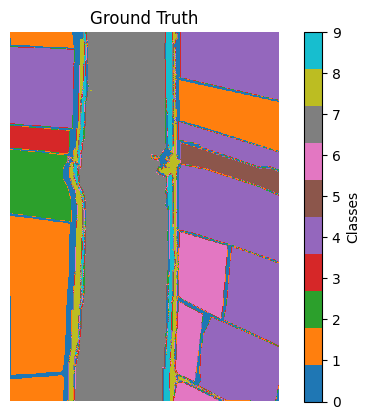

In [7]:
import matplotlib.pyplot as plt

plt.imshow(ground_truth, cmap='tab10')  # Use 'tab10' for categorical labels
plt.title("Ground Truth")
plt.colorbar(label="Classes")
plt.axis("off")
plt.show()

In [8]:
# Normalize data for each band to [0, 1]
image_normalized = (longkou_data - np.min(longkou_data)) / (np.max(longkou_data) - np.min(longkou_data))


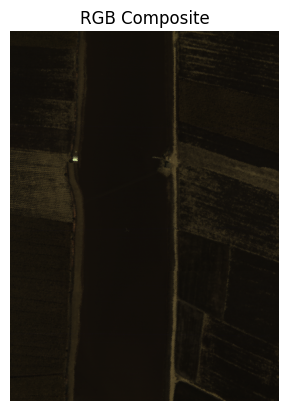

In [9]:
import matplotlib.pyplot as plt

# Select three bands for RGB visualization
red_band = image_normalized[:, :, 50]
green_band = image_normalized[:, :, 30]
blue_band = image_normalized[:, :, 10]

# Stack into an RGB image
rgb_image = np.dstack((red_band, green_band, blue_band))

# Plot the RGB image
plt.imshow(rgb_image)
plt.title("RGB Composite")
plt.axis("off")
plt.show()


In [10]:
#import tensorflow_probability as tfp
import warnings
warnings.filterwarnings("ignore")
K.set_image_data_format('channels_last')

In [11]:
def load_data():
    data = sio.loadmat('/kaggle/input/whu-hyperspectral-dataset/WHU-Hi-LongKou/WHU_Hi_LongKou.mat')['WHU_Hi_LongKou']
    labels = sio.loadmat('/kaggle/input/whu-hyperspectral-dataset/WHU-Hi-LongKou/WHU_Hi_LongKou_gt.mat')['WHU_Hi_LongKou_gt']
    return data, labels

In [12]:
# PCA dimensionality reduction

def applyPCA(X, numComponents=30):
    reshaped_X = X.reshape(-1, X.shape[2])
    pca = PCA(n_components=numComponents, whiten=True)
    X_pca = pca.fit_transform(reshaped_X)
    X_pca = X_pca.reshape(X.shape[0], X.shape[1], numComponents)
    return X_pca, pca

In [13]:
# Zero-padding

def padWithZeros(X, margin=2):
    padded_X = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    padded_X[margin:-margin, margin:-margin, :] = X
    return padded_X

In [14]:
# Extract patches for CNN input

def createPatches(X, y, windowSize=5):
    margin = windowSize // 2
    padded_X = padWithZeros(X, margin)
    patches, labels = [], []
    for r in range(margin, padded_X.shape[0]-margin):
        for c in range(margin, padded_X.shape[1]-margin):
            patch = padded_X[r-margin:r+margin+1, c-margin:c+margin+1, :]
            label = y[r-margin, c-margin]
            if label > 0:
                patches.append(patch)
                labels.append(label-1)
    return np.array(patches), np.array(labels)

In [15]:
# Oversampling weak classes

def oversampleWeakClasses(X, y):
    unique, counts = np.unique(y, return_counts=True)
    maxCount = np.max(counts)
    X_resampled, y_resampled = [], []
    for label in unique:
        count = counts[label]
        idx = np.where(y == label)[0]
        repetitions = maxCount // count
        X_resampled.append(np.repeat(X[idx], repetitions, axis=0))
        y_resampled.append(np.repeat(y[idx], repetitions, axis=0))
    X_new = np.concatenate(X_resampled)
    y_new = np.concatenate(y_resampled)
    shuffle_idx = np.random.permutation(len(y_new))
    return X_new[shuffle_idx], y_new[shuffle_idx]

In [16]:
# Data augmentation

def augmentData(X):
    for i in range(len(X)):
        choice = random.randint(0, 2)
        if choice == 0:
            X[i] = np.flipud(X[i])
        elif choice == 1:
            X[i] = np.fliplr(X[i])
        elif choice == 2:
            angle = random.randint(-15, 15)
            X[i] = scipy.ndimage.rotate(X[i], angle, reshape=False, mode='reflect')
    return X

In [17]:
# Main pipeline

PATCH_SIZE = 5
NUM_COMPONENTS = 30
TEST_RATIO = 0.25
X, y = load_data()

In [18]:
X, pca = applyPCA(X, NUM_COMPONENTS)
X_patches, y_patches = createPatches(X, y, PATCH_SIZE)
X_train, X_test, y_train, y_test = train_test_split(X_patches, y_patches, test_size=TEST_RATIO, stratify=y_patches, random_state=42)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
X_train = augmentData(X_train)

In [19]:
# Normalize
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

In [20]:
# Convert labels to categorical
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)

In [21]:
# Model architecture (2D CNN)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(PATCH_SIZE, PATCH_SIZE, NUM_COMPONENTS)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 3, 3, 32)       │         8,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,057 (54.91 KB)

 Trainable params: 14,057 (54.91 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [23]:
# Train the model
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), batch_size=64, epochs=100, verbose=1, callbacks=[early_stop])

# Evaluation
scores = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

Epoch 1/100


I0000 00:00:1750404933.032494     128 service.cc:145] XLA service 0x7edd54003510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750404933.032551     128 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 106/6457 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.3748 - loss: 2.0848 

I0000 00:00:1750404934.625542     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6457/6457 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9386 - loss: 0.2596 - val_accuracy: 0.9913 - val_loss: 0.0256
Epoch 2/100
6457/6457 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9975 - loss: 0.0096 - val_accuracy: 0.9968 - val_loss: 0.0100
Epoch 3/100
6457/6457 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9963 - val_loss: 0.0121
Epoch 4/100
6457/6457 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9967 - val_loss: 0.0111
Epoch 5/100
6457/6457 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9975 - val_loss: 0.0096
Epoch 6/100
6457/6457 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9998 - loss: 8.8782e-04 - val_accuracy: 0.9977 - val_loss: 0.0098
Epoch 7/100
6457/6457 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9973 - val_loss: 0.0136
Epoch 8/100
6457/6457 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9998 - loss: 8

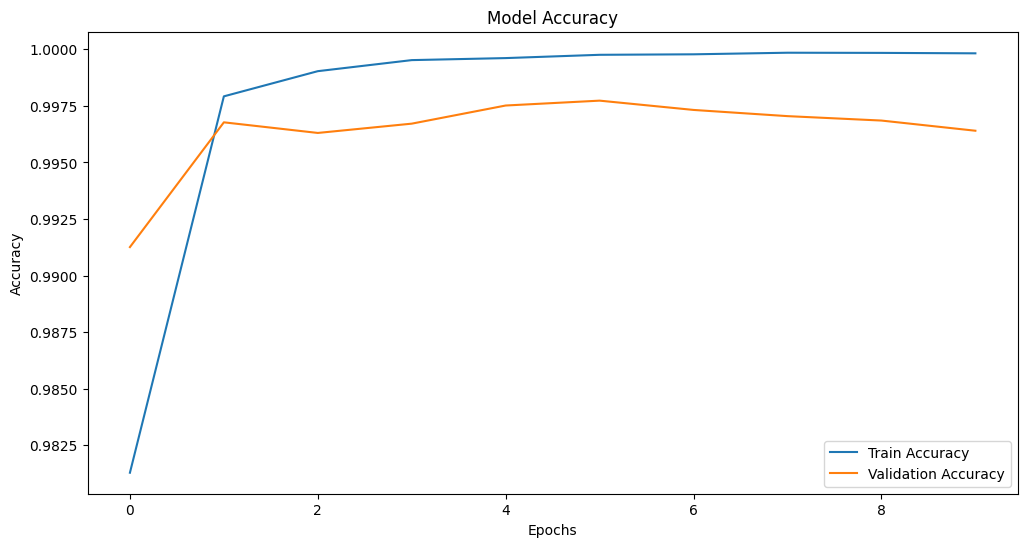

In [43]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


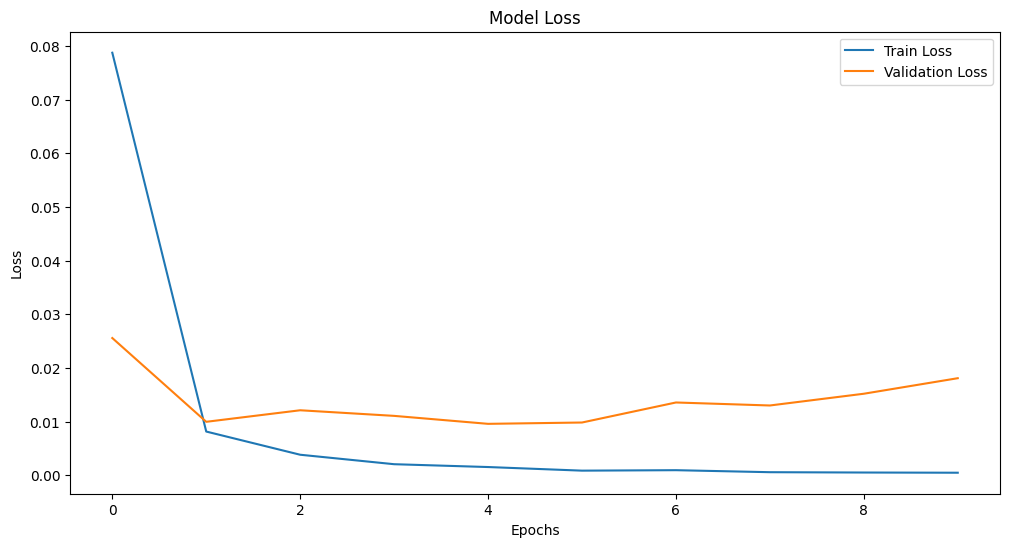

In [44]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# Extract ALL patches for prediction (including unlabeled pixels)
def createAllPatches(X, windowSize=5):
    margin = windowSize // 2
    padded_X = padWithZeros(X, margin)
    patches = []
    coordinates = []
    
    for r in range(margin, padded_X.shape[0]-margin):
        for c in range(margin, padded_X.shape[1]-margin):
            patch = padded_X[r-margin:r+margin+1, c-margin:c+margin+1, :]
            patches.append(patch)
            coordinates.append((r-margin, c-margin))
    
    return np.array(patches), coordinates

In [34]:
# Generate prediction map for entire image
def generatePredictionMap(model, X_pca, windowSize=5, batch_size=1000):
    """
    Generate prediction map for the entire hyperspectral image
    """
    print("Generating prediction map for entire image...")
    
    # Create patches for all pixels
    all_patches, coordinates = createAllPatches(X, windowSize)
    
    # Normalize patches
    all_patches = all_patches / np.max(all_patches)
    
    # Predict in batches to avoid memory issues
    predictions = []
    for i in range(0, len(all_patches), batch_size):
        batch = all_patches[i:i+batch_size]
        batch_predictions = model.predict(batch, verbose=0)
        predictions.append(batch_predictions)
    
    # Combine all predictions
    all_predictions = np.concatenate(predictions, axis=0)
    predicted_labels = np.argmax(all_predictions, axis=1) + 1  # Add 1 to match original label format
    
    # Create prediction map
    prediction_map = np.zeros((X.shape[0], X.shape[1]))
    for i, (r, c) in enumerate(coordinates):
        prediction_map[r, c] = predicted_labels[i]
    
    return prediction_map


In [35]:
# Visualize results
def visualizeResults(ground_truth, prediction_map, class_names=None):
    """
    Display ground truth vs prediction side by side
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Ground Truth
    im1 = axes[0].imshow(ground_truth, cmap='tab20')
    axes[0].set_title('Ground Truth', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Prediction Map
    im2 = axes[1].imshow(prediction_map, cmap='tab20')
    axes[1].set_title('Prediction Map', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Difference Map (highlighting misclassifications)
    difference = np.abs(ground_truth.astype(int) - prediction_map.astype(int))
    difference[ground_truth == 0] = 0  # Don't highlight unlabeled pixels
    im3 = axes[2].imshow(difference, cmap='Reds')
    axes[2].set_title('Difference Map\n(Red = Misclassified)', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    # Add colorbars
    plt.colorbar(im1, ax=axes[0], shrink=0.6)
    plt.colorbar(im2, ax=axes[1], shrink=0.6)
    plt.colorbar(im3, ax=axes[2], shrink=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate overall accuracy for labeled pixels
    labeled_mask = ground_truth > 0
    if np.any(labeled_mask):
        correct_predictions = np.sum(ground_truth[labeled_mask] == prediction_map[labeled_mask])
        total_labeled = np.sum(labeled_mask)
        overall_accuracy = correct_predictions / total_labeled * 100
        print(f"\nOverall Classification Accuracy: {overall_accuracy:.2f}%")
        print(f"Correctly classified pixels: {correct_predictions}/{total_labeled}")



GENERATING PREDICTION MAP
Generating prediction map for entire image...
Displaying results...


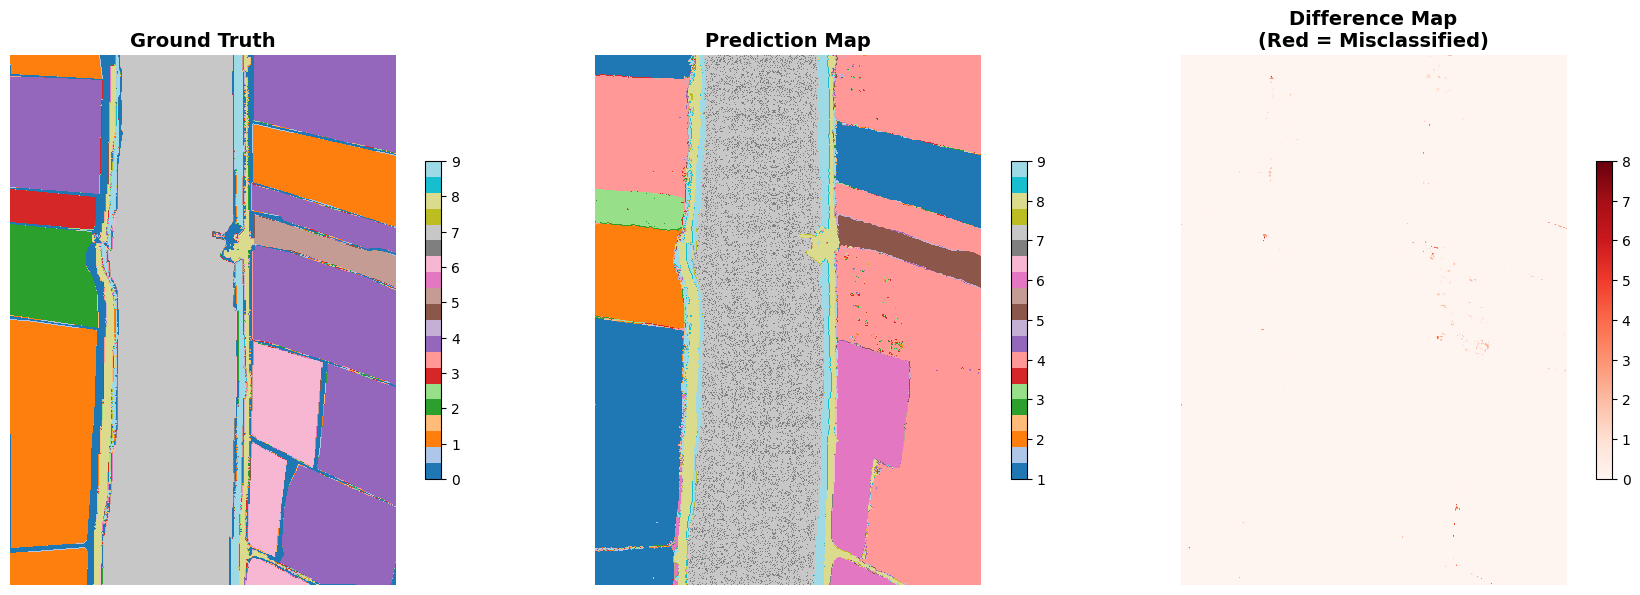


Overall Classification Accuracy: 99.82%
Correctly classified pixels: 204167/204542


In [69]:
# Generate and display prediction map
print("\n" + "="*50)
print("GENERATING PREDICTION MAP")
print("="*50)

prediction_map = generatePredictionMap(model, X, PATCH_SIZE)

# Visualize results
print("Displaying results...")
visualizeResults(y, prediction_map)

In [36]:
# Enhanced visualization with class statistics
def visualizeClassStatistics(ground_truth, prediction_map):
    """
    Show class distribution comparison
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Ground truth class distribution
    gt_unique, gt_counts = np.unique(ground_truth[ground_truth > 0], return_counts=True)
    axes[0].bar(gt_unique, gt_counts, alpha=0.7, color='blue')
    axes[0].set_title('Ground Truth Class Distribution')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Number of Pixels')
    
    # Prediction class distribution
    pred_unique, pred_counts = np.unique(prediction_map[prediction_map > 0], return_counts=True)
    axes[1].bar(pred_unique, pred_counts, alpha=0.7, color='red')
    axes[1].set_title('Predicted Class Distribution')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Number of Pixels')
    
    plt.tight_layout()
    plt.show()


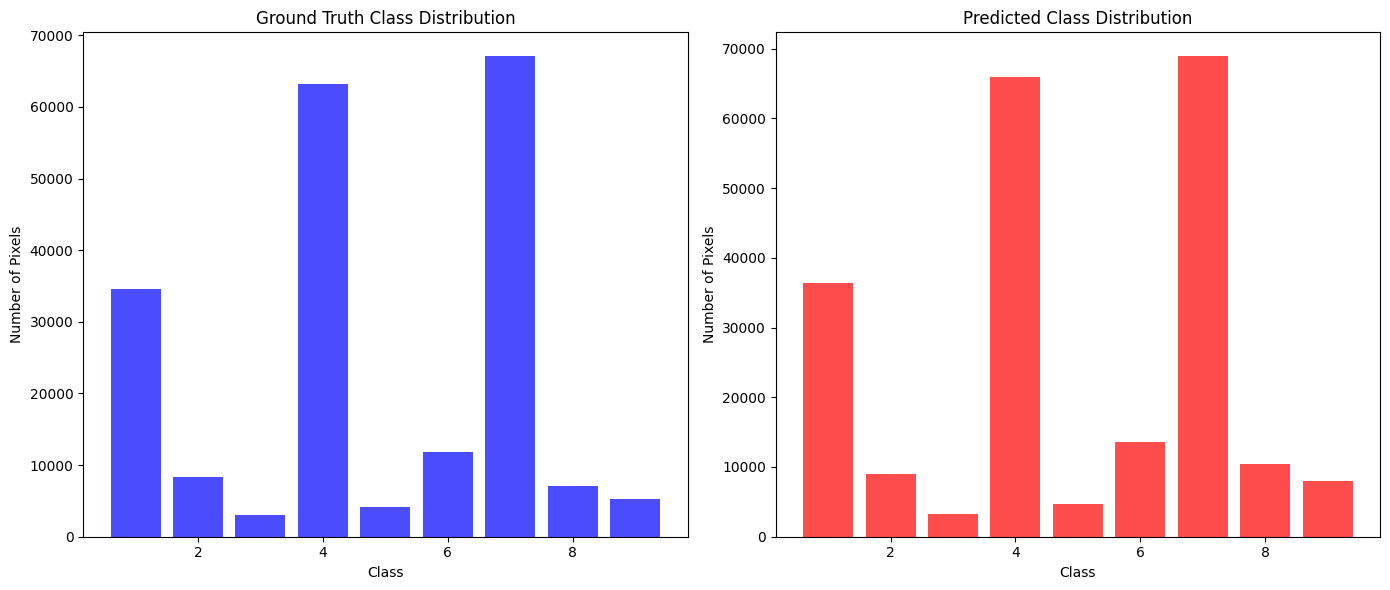

In [70]:
# Show class statistics
visualizeClassStatistics(y, prediction_map)

In [37]:
# Create RGB composite for visualization
def createRGBComposite(original_data, rgb_bands=[29, 19, 9]):
    """
    Create RGB composite from hyperspectral data for visualization
    """
    if len(rgb_bands) != 3:
        rgb_bands = [min(rgb_bands[0], original_data.shape[2]-1),
                     min(rgb_bands[1], original_data.shape[2]-1),
                     min(rgb_bands[2], original_data.shape[2]-1)]
    
    rgb_image = original_data[:, :, rgb_bands]
    
    # Normalize to 0-1 range
    for i in range(3):
        band = rgb_image[:, :, i]
        rgb_image[:, :, i] = (band - np.min(band)) / (np.max(band) - np.min(band))
    
    return rgb_image

Creating RGB composite...
Generating confidence map...
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


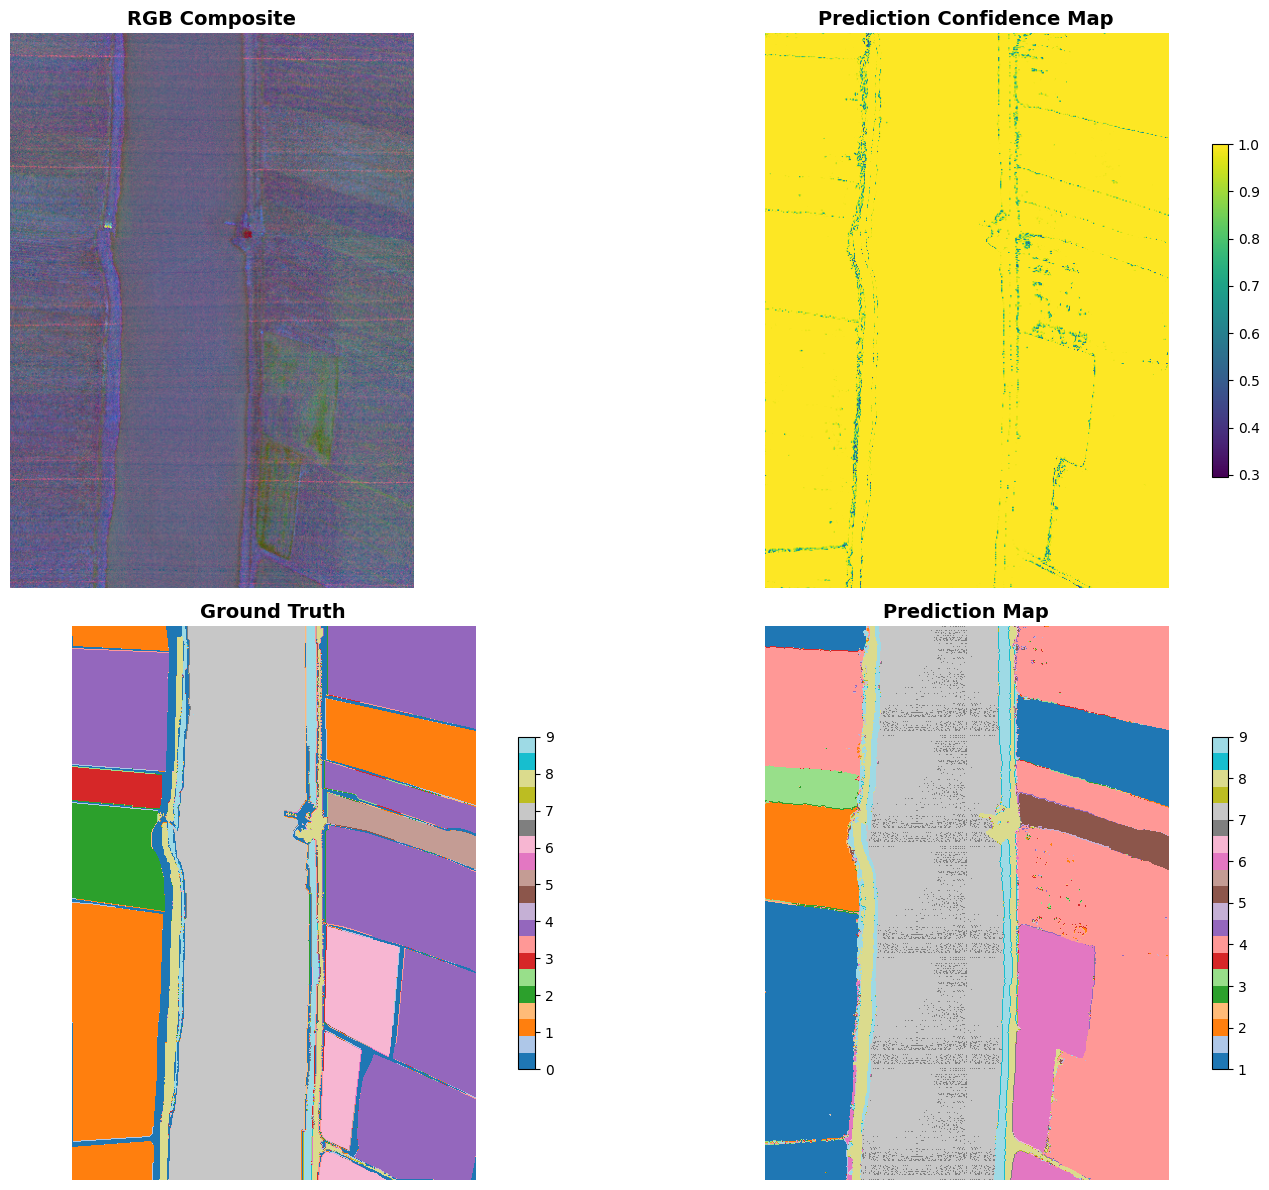

In [75]:
# Create and display RGB composite alongside classification maps
print("Creating RGB composite...")
rgb_composite = createRGBComposite(X)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RGB Composite
axes[0, 0].imshow(rgb_composite)
axes[0, 0].set_title('RGB Composite', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Confidence Map (showing prediction confidence)
# Generate confidence map
print("Generating confidence map...")
all_patches, coordinates = createAllPatches(X, PATCH_SIZE)
all_patches = all_patches / np.max(all_patches)

# Get prediction probabilities
prediction_probs = model.predict(all_patches, batch_size=1000, verbose=1)
max_probs = np.max(prediction_probs, axis=1)

# Create confidence map
confidence_map = np.zeros((X.shape[0], X.shape[1]))
for i, (r, c) in enumerate(coordinates):
    confidence_map[r, c] = max_probs[i]

im3 = axes[0, 1].imshow(confidence_map, cmap='viridis')
axes[0, 1].set_title('Prediction Confidence Map', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im3, ax=axes[0, 1], shrink=0.6)

# Ground Truth
im1 = axes[1, 0].imshow(y, cmap='tab20')
axes[1, 0].set_title('Ground Truth', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0], shrink=0.6)

# Prediction Map
im2 = axes[1, 1].imshow(prediction_map, cmap='tab20')
axes[1, 1].set_title('Prediction Map', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], shrink=0.6)


plt.tight_layout()
plt.show()

In [76]:
print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)
print(f"Model trained on {X_train.shape[0]} samples")
print(f"Test accuracy: {scores[1] * 100:.2f}%")
print(f"Prediction map generated for {X.shape[0]}x{X.shape[1]} pixels")
print(f"Average prediction confidence: {np.mean(max_probs):.3f}")
print(f"Minimum prediction confidence: {np.min(max_probs):.3f}")
print(f"Maximum prediction confidence: {np.max(max_probs):.3f}")


ANALYSIS COMPLETE
Model trained on 413247 samples
Test accuracy: 99.75%
Prediction map generated for 550x400 pixels
Average prediction confidence: 0.995
Minimum prediction confidence: 0.296
Maximum prediction confidence: 1.000


1598/1598 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


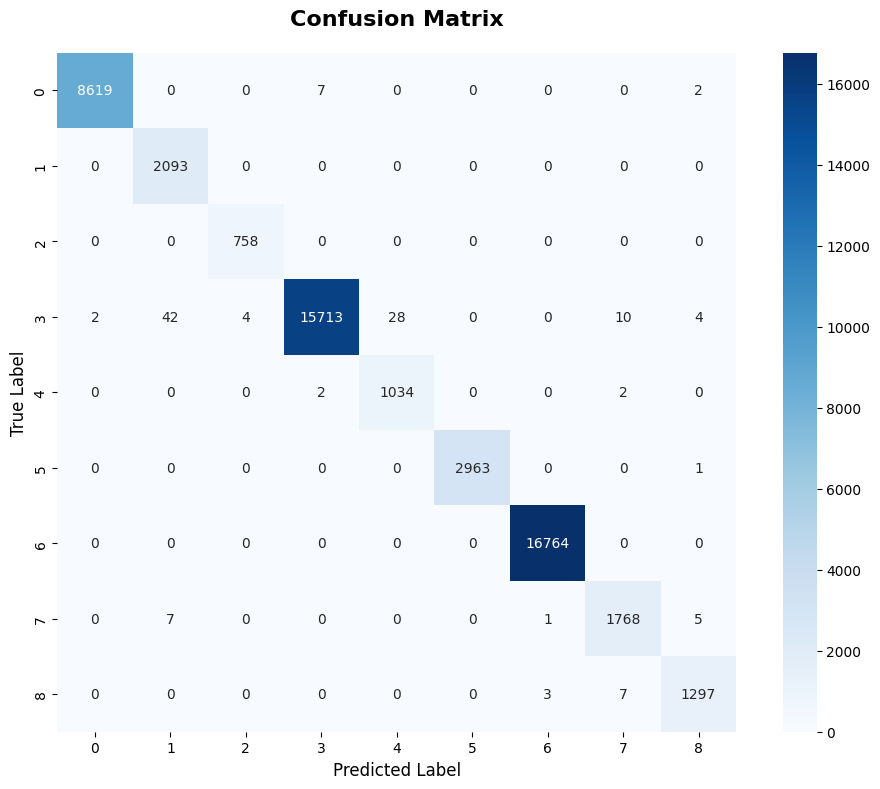

In [80]:
# Get predictions for detailed evaluation
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.title("Confusion Matrix", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

In [82]:
    # Classification Report (printed)
    print("\nCLASSIFICATION REPORT:")
    print("-" * 50)
    report = classification_report(y_true, y_pred, output_dict=True)
    print(classification_report(y_true, y_pred))
    
    # 3. Precision, Recall, F1-Score Plots
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
    


CLASSIFICATION REPORT:
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8628
           1       0.98      1.00      0.99      2093
           2       0.99      1.00      1.00       758
           3       1.00      0.99      1.00     15803
           4       0.97      1.00      0.98      1038
           5       1.00      1.00      1.00      2964
           6       1.00      1.00      1.00     16764
           7       0.99      0.99      0.99      1781
           8       0.99      0.99      0.99      1307

    accuracy                           1.00     51136
   macro avg       0.99      1.00      0.99     51136
weighted avg       1.00      1.00      1.00     51136



In [51]:
import numpy as np

# Get unique labels from the ground truth
unique_labels = np.unique(ground_truth)
print("Unique class labels in the dataset:", unique_labels)


Unique class labels in the dataset: [0 1 2 3 4 5 6 7 8 9]


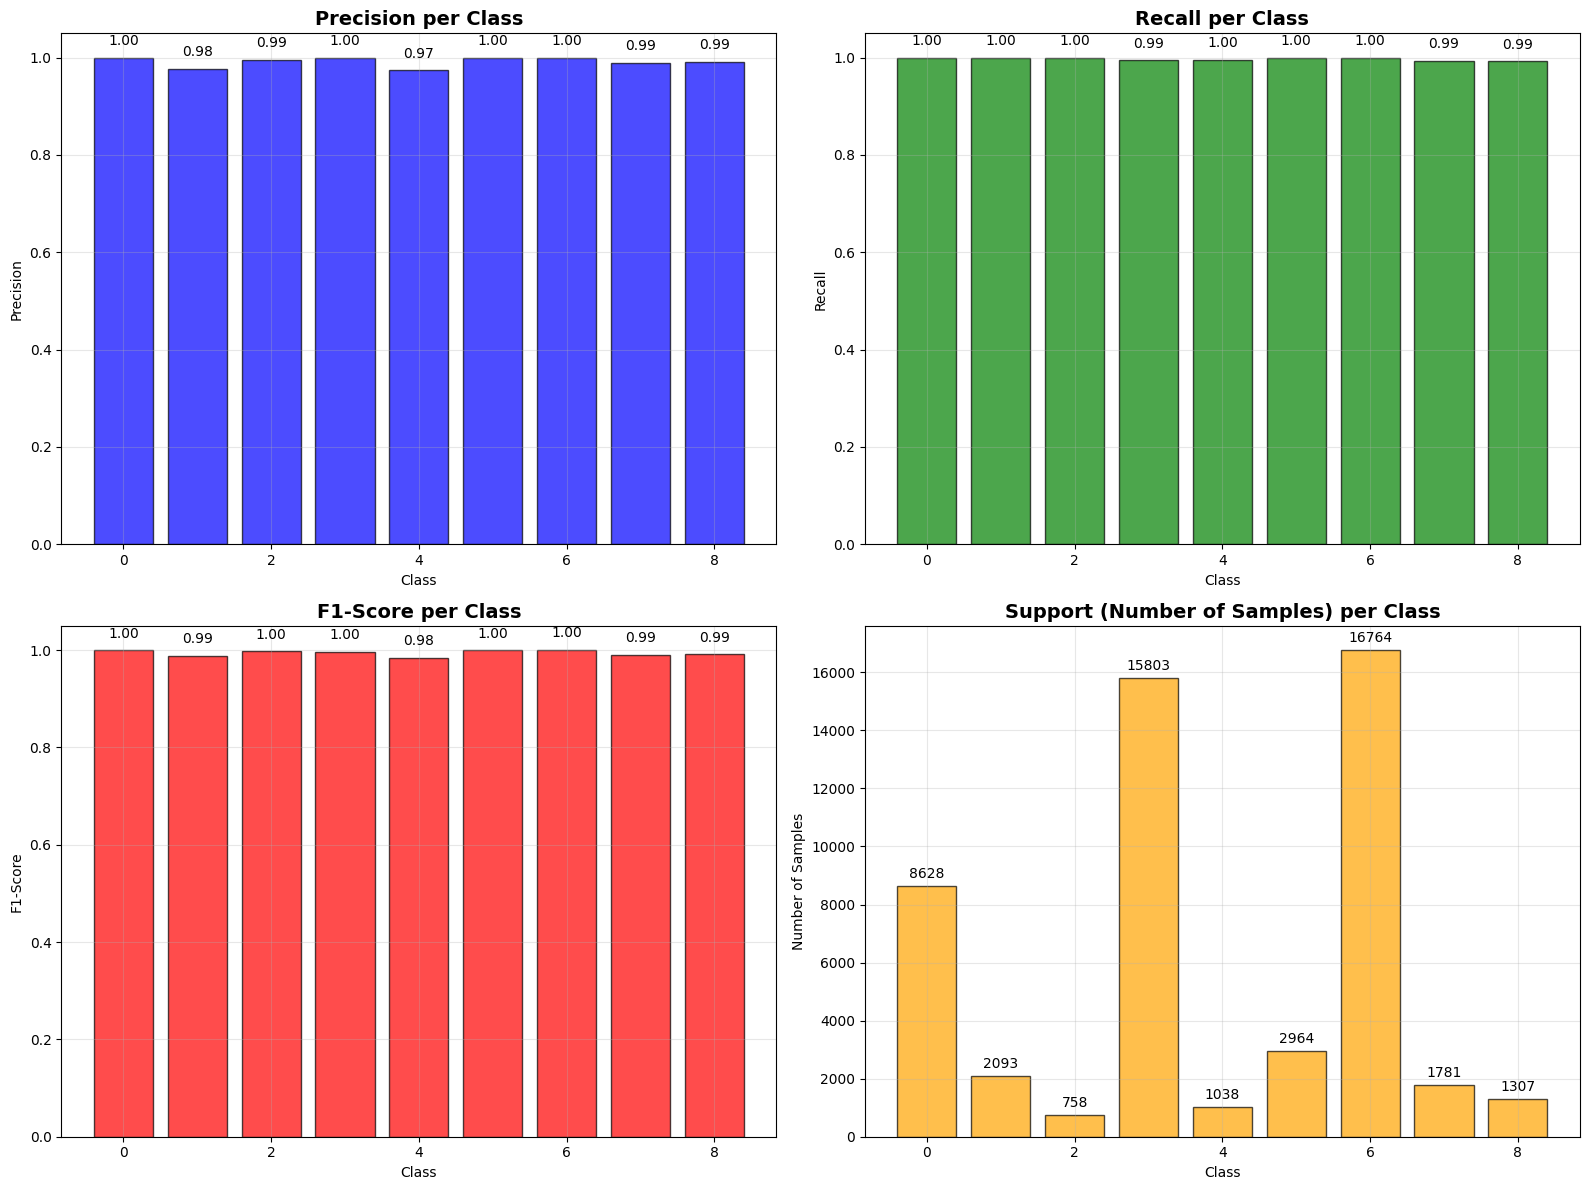

In [85]:
    # Create subplots for metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Precision plot
    classes = range(len(precision))
    axes[0, 0].bar(classes, precision, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Precision per Class', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Precision')
    axes[0, 0].set_ylim(0, 1.05)
    axes[0, 0].grid(True, alpha=0.3)
    for i, v in enumerate(precision):
        axes[0, 0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')
    
    # Recall plot
    axes[0, 1].bar(classes, recall, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Recall per Class', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Class')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].set_ylim(0, 1.05)
    axes[0, 1].grid(True, alpha=0.3)
    for i, v in enumerate(recall):
        axes[0, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')
    
    # F1-Score plot
    axes[1, 0].bar(classes, f1, alpha=0.7, color='red', edgecolor='black')
    axes[1, 0].set_title('F1-Score per Class', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].set_ylim(0, 1.05)
    axes[1, 0].grid(True, alpha=0.3)
    for i, v in enumerate(f1):
        axes[1, 0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')
    
    # Support (number of samples) plot
    axes[1, 1].bar(classes, support, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_title('Support (Number of Samples) per Class', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].grid(True, alpha=0.3)
    for i, v in enumerate(support):
        axes[1, 1].text(i, v + max(support)*0.01, f'{v}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

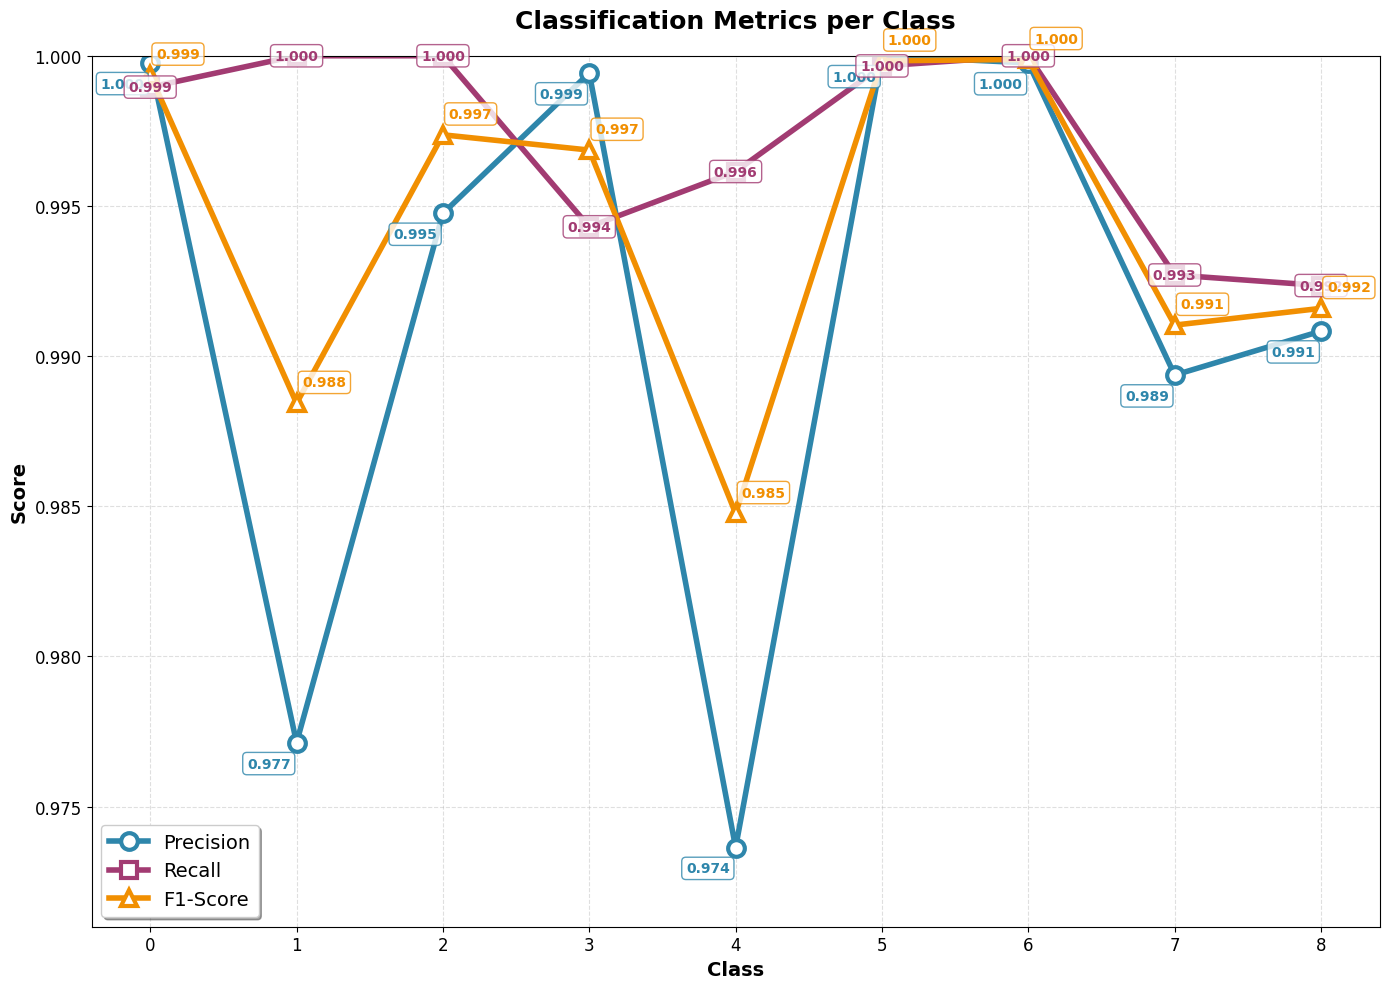


SUMMARY STATISTICS:
------------------------------
Overall Accuracy: 0.9975
Macro Average Precision: 0.9916
Macro Average Recall: 0.9971
Macro Average F1-Score: 0.9943
Weighted Average Precision: 0.9976
Weighted Average Recall: 0.9975
Weighted Average F1-Score: 0.9975


In [87]:
    # Combined Precision & Recall & F1-score Line Plot
    plt.figure(figsize=(14, 10))
    
    # Use different markers and styles for better distinction
    plt.plot(classes, precision, 'o-', label='Precision', linewidth=4, markersize=12, 
             color='#2E86AB', markerfacecolor='white', markeredgewidth=3)
    plt.plot(classes, recall, 's-', label='Recall', linewidth=4, markersize=12, 
             color='#A23B72', markerfacecolor='white', markeredgewidth=3)
    plt.plot(classes, f1, '^-', label='F1-Score', linewidth=4, markersize=12, 
             color='#F18F01', markerfacecolor='white', markeredgewidth=3)
    
    plt.title('Classification Metrics per Class', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Score', fontsize=14, fontweight='bold')
    plt.legend(fontsize=14, loc='lower left', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.4, linestyle='--')
    
    # Set y-axis limits to zoom in on the high-performance range
    min_score = min(min(precision), min(recall), min(f1))
    max_score = max(max(precision), max(recall), max(f1))
    y_range = max_score - min_score
    plt.ylim(max(0, min_score - y_range*0.1), min(1.0, max_score + y_range*0.1))
    
    # Improve x-axis
    plt.xticks(classes, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add value annotations with better positioning
    offset_map = {'precision': -15, 'recall': 0, 'f1': 15}  # Different y-offsets
    colors_map = {'precision': '#2E86AB', 'recall': '#A23B72', 'f1': '#F18F01'}
    
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        # Precision annotations
        plt.annotate(f'{p:.3f}', (i, p), textcoords="offset points", 
                    xytext=(-20, offset_map['precision']), ha='center', va='center',
                    fontsize=10, fontweight='bold', color=colors_map['precision'],
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor=colors_map['precision'], alpha=0.8))
        
        # Recall annotations  
        plt.annotate(f'{r:.3f}', (i, r), textcoords="offset points", 
                    xytext=(0, offset_map['recall']), ha='center', va='center',
                    fontsize=10, fontweight='bold', color=colors_map['recall'],
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor=colors_map['recall'], alpha=0.8))
        
        # F1-Score annotations
        plt.annotate(f'{f:.3f}', (i, f), textcoords="offset points", 
                    xytext=(20, offset_map['f1']), ha='center', va='center',
                    fontsize=10, fontweight='bold', color=colors_map['f1'],
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor=colors_map['f1'], alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 5. Summary Statistics
    print("\nSUMMARY STATISTICS:")
    print("-" * 30)
    print(f"Overall Accuracy: {report['accuracy']:.4f}")
    print(f"Macro Average Precision: {report['macro avg']['precision']:.4f}")
    print(f"Macro Average Recall: {report['macro avg']['recall']:.4f}")
    print(f"Macro Average F1-Score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted Average Precision: {report['weighted avg']['precision']:.4f}")
    print(f"Weighted Average Recall: {report['weighted avg']['recall']:.4f}")
    print(f"Weighted Average F1-Score: {report['weighted avg']['f1-score']:.4f}")